# Continuum + Iron Fitting

In [1]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as fits
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import curve_fit

Opening up a quasar spectrum

In [181]:
spec = fits.open('../../Programs:Coding/spec-0266-51630-0053.fits')
z = spec[2].data['Z']
flux = spec[1].data['flux'] / (1+z)
wav = 10**spec[1].data['loglam'] / (1+z)
ivar = spec[1].data['ivar']
sig = 1/np.sqrt(abs(ivar))

Let's also load in the iron template file, in log space. I'm using Pandas to read in data, but you can use whatever you're familiar with.

In [271]:
iron_template = pd.read_csv('../../Fe_UVtemplt_A.dat', delim_whitespace=True)
iron_wav = iron_template['wavelength'].values
iron_flux = iron_template['flux'].values

Let's plot the template:

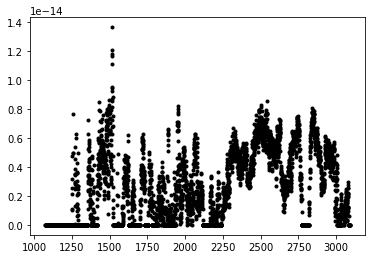

In [272]:
plt.plot(iron_wav, iron_flux, 'k.')

Now for the actual fitting. Let's define a Gaussian where the dispersion will instead be the broadened sigma from Vestergaard+(2001).

In [275]:
def gaussian(x, mu, sigma):
    sigma_conv = np.sqrt(sigma**2 - 900**2) / (2 * np.sqrt(2 * np.log(2)))
    return np.exp(- (x - mu)**2 / (2 * sigma_conv**2))

Next, let's define a function that "rebins" our wavelengths so they are spaced logarithmically. Vestergaard+(2001) says that convolution should be done with log spacing.

In [273]:
def rebin_logspace(x, y):
    log_x = np.log10(x)
    new_x = np.logspace(log_x[1], log_x[-2], len(x))
    return new_x, interp1d(x, y)

In [274]:
log_iron_wav, log_iron_spline = rebin_logspace(iron_wav, iron_flux)

Finally, let's define a functional form for the continuum. We were doing a straight line fit before when we should have been doing a straight line in log-log space (which is a power-law in linear space). Our function will have the form:

$$A \lambda^k + 10^B F_{iron},$$
where $F_{iron}$ is the convolved iron template, and $10^B$ is the normalization for the iron template ($B$ itself ends up being very small)

In [284]:
def fitting_function(lam, A, k, B, mu, sigma):
    iron_convolution = np.convolve(log_iron_spline(lam), gaussian(lam, mu, sigma), mode='same')
    return # Fill in the function

Let's use scipy curve_fit now, and do the fitting for CIV. We should specify bounds for each parameter we're fitting (for example, $A$ should be greater than zero, and probably less than 100). We should also specify initial estimates for each parameter, which we put into $p0$.

In [285]:
ix = ((wav > 1435)&(wav < 1465)) | ((wav > 1690)&(wav < 1710))
bounds = [[lower bounds], [upper bounds]] # Fill in the lower and upper bounds, in the form [[A1, k1, B1, mu1, sigma1], [A2, k2, B2, mu2, sigma2]]
p0 = [10, -2, 13, 1000, 1000] # Parameter estimates in the form [A0, k0, B0, mu0, sigma0]

log_wav, log_flux = rebin_logspace(wav[ix], flux[ix])

pf, covariances = curve_fit(fitting_function, log_wav, log_flux(log_wav), sigma=sig[ix], bounds=bounds, p0=p0)

SyntaxError: invalid syntax (<ipython-input-285-3ce4cfad2db2>, line 2)

curve_fit outputs the best fit estimates for each parameter, as well as the covariance matrix. We can now do the continuum subtraction:

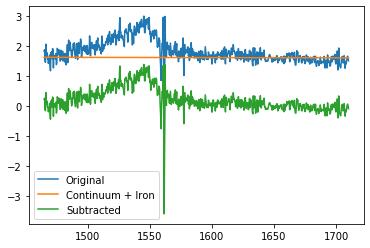

In [281]:
civ_ix = (wav > 1465) & (wav < 1710)

continuum_flux = fitting_function(wav[civ_ix], *popt)

plt.plot(wav[civ_ix], flux[civ_ix], label="Original")

plt.plot(wav[civ_ix], continuum_flux, label='Continuum + Iron')

plt.plot(wav[civ_ix], flux[civ_ix] - continuum_flux, label='Subtracted')
plt.legend()